In [3]:
import site

site.addsitedir("../src")

from pathlib import Path

import pandas as pd

import cpp_game
from ai.actor import ModelBatchActor
from ai.models import load_model_for_eval
from ai.rollout import do_batch_rollout_cpp

%matplotlib inline

In [4]:
model, model_settings = load_model_for_eval(
    Path("/Users/davidzheng/projects/crew-ai/outdirs/0525/run_4")
)
actor = ModelBatchActor(model)
task_defs = model_settings.task_defs

In [5]:
task_defs[0]

('1T 7p with(t)', 'I will win 7p with a submarine.', 3)

In [6]:
cpp_settings = model_settings.to_cpp()
num_rollouts = 10000
batch_rollout = cpp_game.BatchRollout(cpp_settings, num_rollouts)
rows = []


for mode in ["random", "model"]:
    td = do_batch_rollout_cpp(
        batch_rollout,
        actor=(actor if mode == "model" else None),
        batch_seed=42,
        device="cpu",
    )

    for i in range(num_rollouts):
        task_idxs = td["task_idxs_no_pt"][i]
        task_success = td["task_success"][i]
        game_win = td["win"][i].item()
        game_difficulty = sum(task_defs[x][2] for x in task_idxs if x != -1)
        for task_idx, success in zip(task_idxs, task_success):
            if task_idx == -1:
                break
            formula, desc, difficulty = task_defs[task_idx]
            rows.append(
                dict(
                    mode=mode,
                    rollout_idx=i,
                    task_idx=task_idx.item(),
                    formula=formula,
                    task_difficulty=difficulty,
                    task_win=success.item(),
                    game_win=game_win,
                    game_difficulty=game_difficulty,
                    desc=desc,
                )
            )

df = pd.DataFrame(rows)

In [7]:
df.groupby(["mode", "rollout_idx"]).first().groupby(["mode", "game_difficulty"])[
    "game_win"
].mean().unstack("mode")

mode,model,random
game_difficulty,,
4,0.685931,0.051813
5,0.602296,0.025420
6,0.493501,0.011373
7,0.399614,0.004247


In [88]:
df.query("game_difficulty == 5").groupby(["mode", "task_idx"])[
    "task_win"
].mean().unstack("mode").assign(
    delta=lambda df: df["model"] - df["random"]
).sort_values("model")

mode,model,random,delta
task_idx,,,
5,0.281250,0.187500,0.093750
60,0.290323,0.000000,0.290323
9,0.307692,0.076923,0.230769
4,0.321429,0.107143,0.214286
62,0.333333,0.076923,0.256410
...,...,...,...
57,0.957317,0.493902,0.463415
73,0.958333,0.250000,0.708333
68,0.962025,0.556962,0.405063


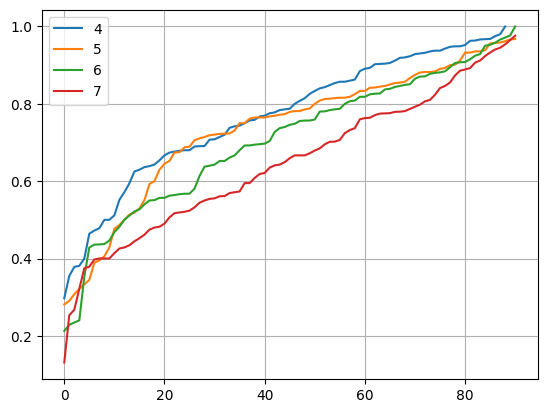

In [ ]:
plot_df = (
    df.query("mode == 'model'")
    .groupby(["game_difficulty", "task_idx"])["task_win"]
    .mean()
    .unstack("game_difficulty")
)
for c in plot_df:
    plot_df[c].sort_values().dropna().reset_index(drop=True).plot(
        label=c, legend=True, grid=True
    )

In [102]:
task_defs[62]

('T0 #T=1', 'I will win only the first trick.', 3)